In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

import sys
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch
import mamba_ssm

print('Python ver:  ', sys.version)
print('Pytorch ver: ', torch.__version__)
print('Mamba ver:   ', mamba_ssm.__version__)
print('GPU in use:  ', torch.cuda.get_device_name(torch.cuda.current_device()))

os.chdir('/mnt/qmtang/EvoFill/')
from src.data import GenotypeEncoder, ImputationDataset
from src.model import EvoFill
from src.utils import setup_workdir, precompute_maf, metrics_by_maf_with95ci, print_maf_stat_df_with95ci

Python ver:   3.10.19 | packaged by conda-forge | (main, Oct 13 2025, 14:08:27) [GCC 14.3.0]
Pytorch ver:  2.8.0+cu129
Mamba ver:    2.2.5
GPU in use:   NVIDIA H100 PCIe


In [5]:
work_dir = Path('/mnt/qmtang/EvoFill_data/20251211_chr22/')
os.chdir(work_dir)
print(f"Work Dir: {work_dir}")

# ---- 1. 加载模型 ----
device = 'cuda' if torch.cuda.is_available() else 'cpu'

json_path = f"{work_dir}/models/model_meta.json"
meta = json.load(open(json_path))
model = EvoFill(
    n_alleles=int(meta["alleles"]),
    total_sites=int(meta["total_sites"]),
    chunk_size=int(meta["chunk_size"]),
    chunk_overlap=int(meta["overlap"]),
    d_model=int(meta["d_model"]),
    d_state=int(meta["d_state"]),
    headdim=int(meta["headdim"]),
    bimamba_layers=int(meta["bimamba_layers"]),
    stack_mamba_layers=int(meta["stack_mamba_layers"])
).to(device)


state_dict = torch.load(f"{work_dir}/models/pytorch_model_stage1.bin", map_location="cpu")
# state_dict = torch.load(f"{work_dir}/models/pytorch_model_stage2.bin", map_location="cpu")

model.load_state_dict(state_dict)
total_params = sum(p.numel() for p in model.parameters())
model.eval()
print(f'[INF] Model[{meta["model_name"]}] loaded.')
print(f"[INF] Total params: {total_params:,}")

Work Dir: /mnt/qmtang/EvoFill_data/20251211_chr22
[INF] Model[hg38_chr22] loaded.
[INF] Total params: 39,503,723


In [6]:
gt_enc_imp = GenotypeEncoder.loadfromdisk(Path(work_dir / "impute_in"))
out_dir = os.path.join(work_dir, 'impute_out')

print(f'[INFER] {gt_enc_imp.n_samples} samples, {gt_enc_imp.n_variants} variants')

# ---- 2. 构建推理 Dataset / Loader ----
imp_dataset = ImputationDataset(
    x_gts_sparse=gt_enc_imp.X_gt,
    seq_depth=gt_enc_imp.seq_depth,
    indices=None                 # 可传入指定样本索引
)
imp_dataset.print_missing_stat()          # 查看原始缺失比例

def collate_fn(batch):
    x_onehot = torch.stack([item[0] for item in batch])
    real_idx_list = [item[1] for item in batch]
    return x_onehot, real_idx_list   # 无 y

imp_loader = torch.utils.data.DataLoader(
    imp_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

y_prob = []
y_mask = []
with torch.no_grad():
    for x_onehot, real_idx in tqdm(imp_loader, desc='Imputing'):
        x_onehot = x_onehot.to(device)
        _, prob, _ = model(x_onehot)
        miss_mask = x_onehot[..., -1].bool()
        y_prob.append(prob)
        y_mask.append(miss_mask)
y_prob = torch.cat(y_prob, dim=0).cpu().numpy()
y_mask = torch.cat(y_mask, dim=0).cpu().numpy()

# 4. 保存
os.makedirs(out_dir, exist_ok=True)
np.save(os.path.join(out_dir, 'impute_prob.npy'), y_prob)
np.save(os.path.join(out_dir, 'impute_mask.npy'), y_mask)
print(f'[INF] 概率矩阵已保存 → {out_dir}/impute_prob.npy '
      f'with shape = {y_prob.shape} ')


[INFER] 93 samples, 190184 variants
[INFER] 93 samples, missing rate = 89.93%


Imputing: 100%|██████████| 93/93 [00:25<00:00,  3.58it/s]


[INF] 概率矩阵已保存 → /mnt/qmtang/EvoFill_data/20251211_chr22/impute_out/impute_prob.npy with shape = (93, 190184, 3) 


In [7]:
gt_enc_true = GenotypeEncoder.loadfromdisk(Path(work_dir / "impute_out"))
y_true = gt_enc_true.X_gt.toarray()
maf, bin_cnt = precompute_maf(y_true)
y_true_oh = np.eye(gt_enc_true.seq_depth - 1)[y_true]
bins_metrics   = metrics_by_maf_with95ci(y_prob, y_true_oh, hap_map = gt_enc_true.hap_map, maf_vec = maf, mask=y_mask)
print_maf_stat_df_with95ci(bin_cnt,{'val': bins_metrics})

     MAF_bin Counts val_Acc val_INFO val_IQS val_MaCH   val_Acc_CI95  val_INFO_CI95   val_IQS_CI95  val_MaCH_CI95
(0.00, 0.05) 109870   0.994    0.145   0.141    0.757 [0.993, 0.994] [0.143, 0.147] [0.139, 0.143] [0.755, 0.760]
(0.05, 0.10)  15765   0.951    0.643   0.653    0.732 [0.950, 0.952] [0.636, 0.649] [0.646, 0.659] [0.725, 0.738]
(0.10, 0.20)  22521   0.932    0.719   0.723    0.807 [0.931, 0.934] [0.714, 0.723] [0.718, 0.728] [0.802, 0.812]
(0.20, 0.30)  14896   0.915    0.756   0.749    0.842 [0.913, 0.917] [0.751, 0.762] [0.743, 0.754] [0.837, 0.848]
(0.30, 0.40)  13774   0.909    0.778   0.761    0.858 [0.907, 0.912] [0.772, 0.783] [0.755, 0.767] [0.852, 0.863]
(0.40, 0.50)  12984   0.909    0.782   0.760    0.856 [0.906, 0.912] [0.777, 0.788] [0.754, 0.766] [0.851, 0.862]


| 区域名称              | 功能类型       | hg38位置                       | 代表性变异                       | 主要关联表型           |
| ----------------- | ---------- | ---------------------------- | --------------------------- | ---------------- |
| APOL1             | 先天免疫/人群分化  | chr22:36,253,071-36,267,530  | G1, G2等位基因                  | 肾病、锥虫抗性、非洲人群分化高度 |
| IGL@ (免疫球蛋白λ)     | 适应免疫       | chr22:22,024,092-22,944,092  | IGLV、IGLJ、IGLC多态性           | 抗体多样性、免疫应答个体差异   |
| 22q11.23 (MIF基因簇) | 免疫调节/环境适应  | chr22:~23,000,000-23,120,000 | CNV_22q11.23_A/B、MIF启动子SNPs | UV适应、先天免疫强度、人群分化 |
| PNPLA3            | 脂肪代谢       | chr22:43,923,805-43,947,582  | rs738409 (I148M)            | 非酒精性脂肪肝、肝脂肪变性    |
| TBX1              | 免疫发育/心血管发育 | chr22:19,756,703-19,783,593  | rs5746161等(>355个SNPs)       | 胸腺发育、先天性心脏病、免疫缺陷 |

---

| 区域名称   | 功能类型      | hg38位置                       | 代表性变异                         | 主要关联表型                |
| ------ | --------- | ---------------------------- | ----------------------------- | --------------------- |
| FADS1  | 脂肪代谢      | chr6:61,384,801-61,430,810   | rs174537、rs174545、rs174546    | LC-PUFA代谢、肥胖、血脂异常     |
| FADS2  | 脂肪代谢      | chr6:61,422,308-61,467,066   | rs2727270、rs174548、rs174560   | LC-PUFA代谢、脂肪酸去饱和      |
| CDKAL1 | 2型糖尿病易感   | chr6:20,680,017-20,700,043   | rs4712523、rs4712524、rs9460546 | 2型糖尿病风险↑1.24倍、β细胞功能障碍 |
| TNF    | 免疫调节/炎症   | chr6:31,575,565-31,578,336   | rs1800629 (-308G/A)、rs361525  | 炎症肌病、肺纤维化、免疫应答强度      |
| EPHA1  | 血脑屏障/神经血管 | chr6:105,362,618-105,434,991 | P460L、R492Q、R926C             | 晚发性阿尔茨海默病、小血管病变       |
| LY6G6D | 先天免疫      | chr6:~30,800,000-30,900,000  | 多个SNPs和甲基化位点                  | 中性粒细胞浸润、先天免疫强度        |
| MHC（HLA 超位点）    | 适应免疫 / 移植 / 自免 | chr6:28,510,120–33,480,577 | HLA-A/B/C, HLA-DRB1/DQB1/DPB1    | 移植排斥、自身免疫、感染易感​ |
| MHC Class I 区   | 抗病毒免疫          | ~chr6:29.9M–31.6M          | HLA-A/B/C/E/F/G                  | 病毒控制、NK 识别   |
| MHC Class II 区  | CD4 T 细胞应答     | ~chr6:32.5M–33.4M          | HLA-DRB1/DQB1/DPB1               | 自身免疫（RA、T1D 等）|
| MHC Class III 区 | 炎症 / 补体        | ~chr6:31.6M–32.5M          | TNF, LTA, C2, C4, MICA/B, LY6G6D | 炎症性疾病、肿瘤、NPC        |

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.makedirs("plots", exist_ok=True)

region_name = "IGL@"
region_start = 22024092   # 比如 19000000，None 表示从最小坐标
region_end   = 22944092   # 比如 22000000，None 表示到最大坐标

# bin 数量（沿着基因组位置分成多少个区段）
N_BINS = 100

# MAF 分层（可以按需修改）
maf_bins = [0.0, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
maf_labels = [
    "0–0.05",
    "0.05–0.10",
    "0.10–0.20",
    "0.20–0.30",
    "0.30–0.40",
    "0.40–0.50"
]

# ===================== #
# 2. 读取位点坐标
# ===================== #

# 文件名为 gt_variants.txt，和 y_prob 对应顺序完全一致
var_df = pd.read_csv(f"{work_dir}/train/gt_variants.txt", header=None, names=["variant"])

# variant 形如 "chr22:10519276_G/C"
# 提取坐标
def parse_pos(s):
    # 'chr22:10519276_G/C' -> 10519276
    pos_part = s.split(':')[1].split('_')[0]
    return int(pos_part)

var_df["pos"] = var_df["variant"].apply(parse_pos)
positions = var_df["pos"].values  # shape (190184,)

# 按需要裁剪区间
if region_start is None:
    region_start = positions.min()
if region_end is None:
    region_end = positions.max()

region_mask = (positions >= region_start) & (positions <= region_end)
region_idx = np.where(region_mask)[0]

if len(region_idx) == 0:
    raise ValueError("给定坐标区间内没有位点，请检查 region_start / region_end 或数据。")

pos_region = positions[region_idx]

# ===================== #
# 3. 从 y_true_oh, y_prob, y_mask 计算 per-SNP 精度与 MAF
# ===================== #

n_samples, n_snps, n_classes = y_prob.shape

# 只取区域内 SNP
y_prob_region = y_prob[:, region_idx, :]          # (n_samples, n_snps_region, 3)
y_true_oh_region = y_true_oh[:, region_idx, :]    # (n_samples, n_snps_region, 3)
y_mask_region = y_mask[:, region_idx]             # (n_samples, n_snps_region)

# true genotype & predicted genotype
y_true_label = y_true_oh_region.argmax(axis=2)    # (n_samples, n_snps_region)
y_pred_label = y_prob_region.argmax(axis=2)       # (n_samples, n_snps_region)

# 只在 mask==1 的地方评估
valid_mask = (y_mask_region == 1)

# per-SNP accuracy: 对每一列（每个 SNP）在所有样本上的准确率
# 注意：要避免分母为 0
per_snp_acc = []
per_snp_maf = []

for j in range(y_true_label.shape[1]):
    m = valid_mask[:, j]
    if not np.any(m):
        # 该 SNP 在这个区域内没有需要评估的样本，用 np.nan 填
        per_snp_acc.append(np.nan)
        per_snp_maf.append(np.nan)
        continue

    true_j = y_true_label[m, j]
    pred_j = y_pred_label[m, j]

    acc = (true_j == pred_j).mean()
    per_snp_acc.append(acc)

    # 这里假设 3 类编码为 0,1,2，且 2 是 alt/alt，可以用简单办法估 MAF
    # 也可以根据你自己的编码方式重新定义
    # genotype: 0,1,2 -> alt allele count / 2 即为 alt allele frequency
    af = true_j.mean() / 2.0
    maf = min(af, 1 - af)
    per_snp_maf.append(maf)

per_snp_acc = np.array(per_snp_acc)  # (n_snps_region,)
per_snp_maf = np.array(per_snp_maf)  # (n_snps_region,)

# # 去掉全 nan 的位点（如果需要）
# valid_snp_mask = ~np.isnan(per_snp_acc)
# pos_region = pos_region[valid_snp_mask]
# per_snp_acc = per_snp_acc[valid_snp_mask]
# per_snp_maf = per_snp_maf[valid_snp_mask]


In [10]:
model1_snp_acc = np.array(per_snp_acc)  # (n_snps_region,)
model1_snp_acc.shape

(7182,)

In [17]:
model2_snp_acc = np.array(per_snp_acc)  # (n_snps_region,)
model2_snp_acc.shape

(7182,)

In [34]:
positions.shape

(190184,)

### 1. heatmap

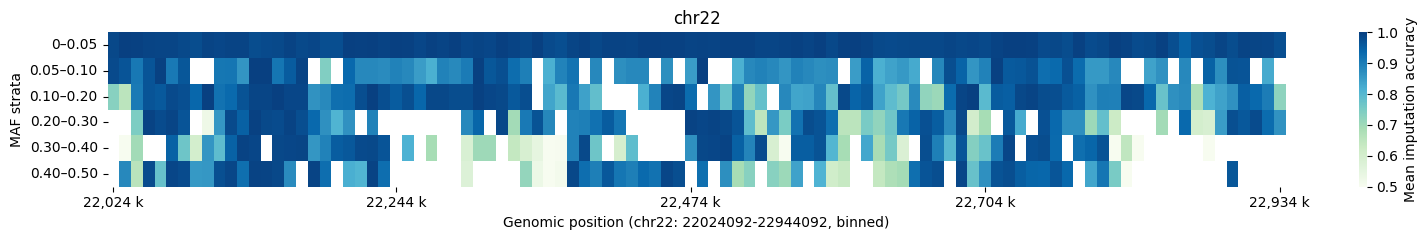

In [ ]:
# ===================== #
# 4. 按位置分 bin，再按 MAF 分层，构建热力图矩阵
# ===================== #

# 位置分 bin
bin_edges = np.linspace(region_start, region_end, N_BINS + 1)
bin_ids = np.digitize(pos_region, bins=bin_edges) - 1  # 0 ~ N_BINS-1

# MAF 分层
maf_cat = pd.cut(per_snp_maf, bins=maf_bins, labels=maf_labels, right=True, include_lowest=True)
maf_cat = np.array(maf_cat)

# 初始化矩阵：行=MAF 层，列=位置 bin
heat_mat = np.full((len(maf_labels), N_BINS), np.nan, dtype=float)

for i, maf_label in enumerate(maf_labels):
    mask_maf = (maf_cat == maf_label)
    if not np.any(mask_maf):
        continue
    for b in range(N_BINS):
        mask_bin = (bin_ids == b)
        m = mask_maf & mask_bin
        if not np.any(m):
            continue
        heat_mat[i, b] = per_snp_acc[m].mean()

# ===================== #
# 5. 画分层区域热力图
# ===================== #

plt.figure(figsize=(16, 1 + 0.25 * len(maf_labels)))

# 使用 seaborn 画热力图
sns.heatmap(
    heat_mat,
    vmin=0.5, vmax=1.0,
    cmap="GnBu",
    xticklabels=False,    # x 轴 tick 太多可以先关掉
    yticklabels=maf_labels,
    cbar_kws={"label": "Mean imputation accuracy"}
)

# x 轴标出几个关键坐标
xticks_pos = np.linspace(0, N_BINS - 1, 5, dtype=int)
xticks_labels = [
    f"{int(bin_edges[t]/1e3):,} k" for t in xticks_pos
]
plt.xticks(xticks_pos + 0.5, xticks_labels, rotation=0)

plt.xlabel(f"Genomic position (chr22: {region_start}-{region_end}, binned)")
plt.ylabel("MAF strata")
plt.title(region_name)

plt.tight_layout()
out_path = f"plots/imputation_heatmap {region_name}(chr22 {region_start}-{region_end}).svg"
plt.savefig(out_path, format="svg")
plt.show()


In [9]:
heat_mat_1 = heat_mat.copy()

In [18]:
heat_mat_2 = heat_mat.copy()

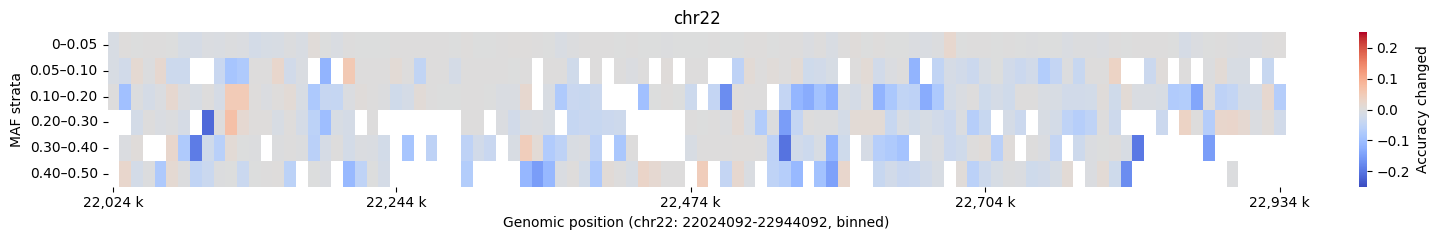

In [25]:
plt.figure(figsize=(16, 1 + 0.25 * len(maf_labels)))

# 使用 seaborn 画热力图
sns.heatmap(
    heat_mat_2-heat_mat_1,
    vmin=-0.25, vmax=0.25,
    cmap="coolwarm",
    xticklabels=False,    # x 轴 tick 太多可以先关掉
    yticklabels=maf_labels,
    cbar_kws={"label": "Accuracy changed"}
)

# x 轴标出几个关键坐标
xticks_pos = np.linspace(0, N_BINS - 1, 5, dtype=int)
xticks_labels = [
    f"{int(bin_edges[t]/1e3):,} k" for t in xticks_pos
]
plt.xticks(xticks_pos + 0.5, xticks_labels, rotation=0)

plt.xlabel(f"Genomic position (chr22: {region_start}-{region_end}, binned)")
plt.ylabel("MAF strata")
plt.title(region_name)

plt.tight_layout()
# out_path = f"plots/imputation_heatmap_del5a {region_name}(chr22 {region_start}-{region_end}).svg"
# plt.savefig(out_path, format="svg")
plt.show()

### 2. LD cal

In [ ]:
import allel
from scipy.spatial.distance import squareform
callset = allel.read_vcf("/mnt/qmtang/EvoFill_data/20251211_chr22/data/major_pops_val.vcf.gz")
g = allel.GenotypeArray(callset['calldata/GT'][callset['variants/CHROM'] == 'chr22'])
gn = g.to_n_alt(fill=-1)
r = allel.rogers_huff_r(gn)
LD = squareform(r ** 2)
np.save("/mnt/qmtang/EvoFill_data/20251211_chr22/data/major_pops_val_chr22LD.npy",LD)

In [18]:
LD = np.load("/mnt/qmtang/EvoFill_data/20251211_chr22/data/minor_pops_all_chr22LD.npy")
LD.shape

(190184, 190184)

In [19]:
region_idx.shape

(7182,)

### 3. LD map

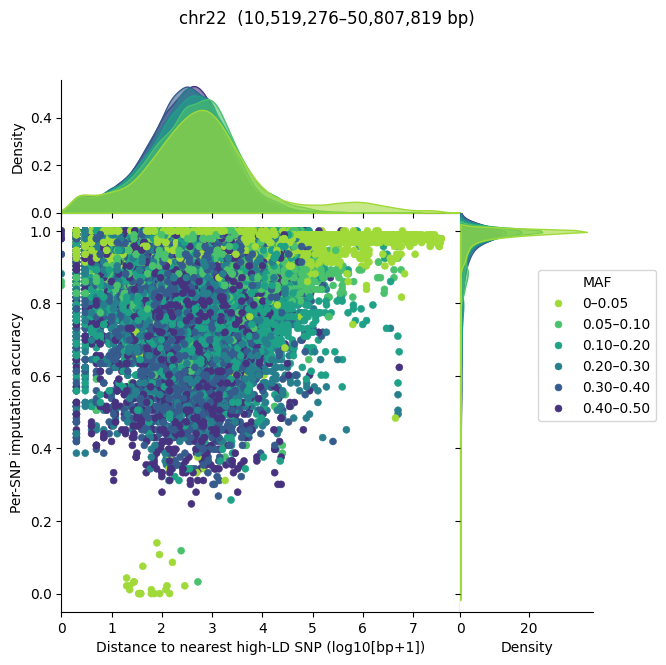

In [159]:
# ===================== #
# 5. 计算 ld_dist：到最近高-LD 参考 SNP 的物理距离
# ===================== #
# 参考 SNP 定义：r²≥0.8 且位于同一 region 内

ld_region = LD[np.ix_(region_idx, region_idx)]          # (n_snps_region, n_snps_region)
high_ld_thr = 0.8

# 对每个 SNP j，找满足 r²≥0.8 的其他 SNP k（k≠j）
ld_dist = np.full(len(pos_region), np.nan)               # 最终长度 = n_snps_region

for j in range(len(pos_region)):
    r2_j = ld_region[:, j]                 # 长度 426 的向量
    candidates = np.where(r2_j >= high_ld_thr)[0]  # 这些已经是 0…425 的“局部”下标
    candidates = candidates[candidates != j]
    if len(candidates) == 0:
        continue
    # 直接拿局部下标索引 pos_region
    pos_candidates = pos_region[candidates]
    dists = np.abs(pos_candidates - pos_region[j])
    ld_dist[j] = dists.min()

# ===================== #
# 6. 整理成 DataFrame 并过滤掉无 ld_dist 的位点
# ===================== #
df_plot = pd.DataFrame({
    'pos': pos_region,
    'acc': per_snp_acc,
    'maf': per_snp_maf,
    'ld_dist': ld_dist
})
# 去掉没有高-LD 伙伴的位点（可选；若想保留可把 ld_dist 设为很大值并单独设色）
df_plot = df_plot.dropna(subset=['ld_dist'])
df_plot['log_ld_dist'] = np.log10(df_plot['ld_dist'] + 1)   # +1 避免 0 bp 取 log 为-inf

# MAF 分层（已在前文用 pd.cut 得到 maf_cat，这里重新对应）
df_plot['maf_cat'] = pd.cut(df_plot['maf'],
                            bins=maf_bins,
                            labels=maf_labels,
                            right=True,
                            include_lowest=True)



from matplotlib.colors import to_rgba
import seaborn as sns

x_min, x_max = df_plot['log_ld_dist'].min(), df_plot['log_ld_dist'].max()
# 1. 建立画布与网格（同上一版）
fig = plt.figure(figsize=(7, 7))
gs = fig.add_gridspec(4, 4,
                      hspace=0.0, wspace=0.0,
                      left=0.12, right=0.88, bottom=0.12, top=0.88)

# 2. 主 scatter（复用上一版数据）
ax_main = fig.add_subplot(gs[1:, :-1])
sns.scatterplot(data=df_plot,
                x='log_ld_dist',
                y='acc',
                hue='maf_cat',
                palette='viridis_r',
                s=25,
                edgecolor=None,
                ax=ax_main)
ax_main.set_xlabel('Distance to nearest high-LD SNP (log10[bp+1])')
ax_main.set_ylabel('Per-SNP imputation accuracy')
ax_main.set_xlim(0.95*x_min,1.05*x_max)
ax_main.set_ylim(-0.05, 1.05)
# 把 legend 移到图外
handles, labels = ax_main.get_legend_handles_labels()
ax_main.legend_.remove()   # 先去掉默认 legend，后面统一放

# 3. 上方 X 轴密度（分层）
ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)
for maf_lab in maf_labels[::-1]:              # 从深到浅叠，防止浅色被盖住
    sub = df_plot[df_plot['maf_cat'] == maf_lab]
    color = sns.color_palette('viridis_r', n_colors=len(maf_labels))[maf_labels.index(maf_lab)]
    sns.kdeplot(sub['log_ld_dist'],
                ax=ax_top,
                color=color,
                fill=True, alpha=0.6,
                linewidth=1)
ax_top.set_ylabel('Density')
ax_top.set_xlabel(None)
ax_top.tick_params(axis='x', labelbottom=False)
sns.despine(ax=ax_top, bottom=True)

# 4. 右侧 Y 轴密度（分层）
ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
for maf_lab in maf_labels[::-1]:
    sub = df_plot[df_plot['maf_cat'] == maf_lab]
    color = sns.color_palette('viridis_r', n_colors=len(maf_labels))[maf_labels.index(maf_lab)]
    # 把 acc 作为 y 轴数据即可实现“垂直”密度图
    sns.kdeplot(y=sub['acc'],
                ax=ax_right,
                color=color,
                fill=True, alpha=0.6,
                linewidth=1)
ax_right.set_xlabel('Density')
ax_right.set_ylabel(None)
ax_right.tick_params(axis='y', labelleft=False)
sns.despine(ax=ax_right, left=True)

# 5. 统一 legend（放在右侧）
fig.legend(handles, labels,
          loc='center right',
          bbox_to_anchor=(0.98, 0.5),
          title='MAF')
# 6. 总标题
fig.suptitle(f'{region_name}  ({region_start:,}–{region_end:,} bp)',
            y=0.98)

out_path = f"plots/ld_dist_vs_acc_maf {region_name}(chr22 {region_start}-{region_end}).svg"
fig.savefig(out_path, format='svg', dpi=300)

plt.show()

Indexing VCF1 ...
VCF1 indexed: 190184 sites
Scanning VCF2 ...
Shared sites: 188430
ΔAF  mean = -0.0054, std = 0.0654
|ΔAF|>0.1 比例 = 12.61%


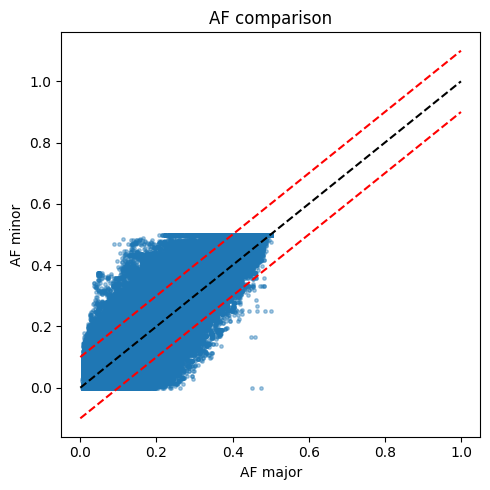

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from cyvcf2 import VCF

vcf1_path = "/mnt/qmtang/EvoFill_data/20251211_chr22/data/major_pops_train.vcf.gz"
vcf2_path = "/mnt/qmtang/EvoFill_data/20251211_chr22/data/minor_pops_all.vcf.gz"

# 1. 索引 VCF1
print("Indexing VCF1 ...")
af1_dict = {}
vcf1 = VCF(vcf1_path)
for variant in vcf1:
    key = (variant.CHROM, variant.POS, variant.REF, variant.ALT[0])
    gts = variant.gt_types          # 0/1/2/3
    mask = gts != 3
    if mask.sum() == 0:
        continue
    alt_count = (gts[mask] > 0).sum() + (gts[mask] == 2).sum()
    af = alt_count / (mask.sum() * 2)
    af1_dict[key] = af
vcf1.close()
print(f"VCF1 indexed: {len(af1_dict)} sites")

# 2. 扫描 VCF2 并计算 ΔAF
print("Scanning VCF2 ...")
af1_list, af2_list, keys = [], [], []
vcf2 = VCF(vcf2_path)
for variant in vcf2:
    key = (variant.CHROM, variant.POS, variant.REF, variant.ALT[0])
    if key not in af1_dict:
        continue
    gts = variant.gt_types
    mask = gts != 3
    if mask.sum() == 0:
        continue
    alt_count = (gts[mask] > 0).sum() + (gts[mask] == 2).sum()
    af2 = alt_count / (mask.sum() * 2)
    af1 = af1_dict[key]
    af1_list.append(af1)
    af2_list.append(af2)
    keys.append(key)
vcf2.close()

# 3. 统计 & 绘图
af1_vec = np.array(af1_list)
af2_vec = np.array(af2_list)
delta = af2_vec - af1_vec

print(f"Shared sites: {len(delta)}")
print(f"ΔAF  mean = {delta.mean():.4f}, std = {delta.std():.4f}")
print(f"|ΔAF|>0.1 比例 = {(np.abs(delta)>0.1).mean():.2%}")



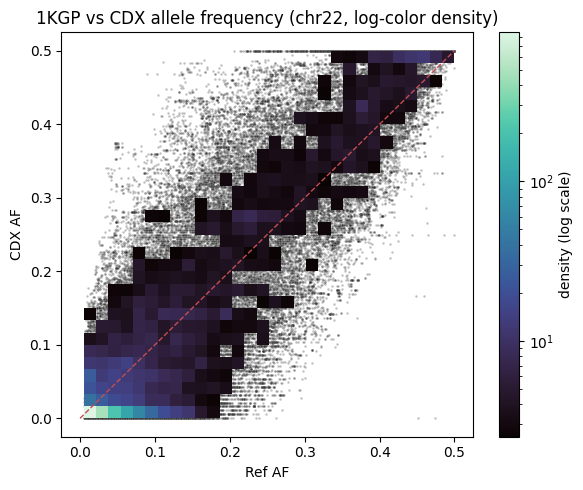

In [53]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

sns.reset_defaults()   # 退出 seaborn 主题
plt.rcParams.update(plt.rcParamsDefault)  # 再保险地把 rc 参数也清掉

f, ax = plt.subplots(figsize=(6, 5))

# 1. 画二维直方图，但不要 colorbar
h = sns.histplot(
        x=af1_vec, y=af2_vec,
        bins=30,                  # 可以调更细
        pthresh=.1,               # 低于此阈值直接透明
        cmap="mako",
        stat="density",           # 关键：用密度而不是计数
        cbar=False,                # 暂时不要 colorbar
        zorder=2
)

# 2. 把图像对象拿出来，改归一化
quadmesh = h.collections[0]          # QuadMesh
values = quadmesh.get_array()        # 原始密度值
vmin = np.nanmin(values[values > 0]) # 去掉 0
vmax = np.nanmax(values)

# 3. 重新挂一个 log 归一化的颜色映射
quadmesh.set_norm(LogNorm(vmin=vmin, vmax=vmax))

# 4. 手动加 colorbar
cbar = f.colorbar(quadmesh, ax=ax)
cbar.set_label('density (log scale)')

# 5. 散点叠上去（可选，透明度调低）
sns.scatterplot(x=af1_vec, y=af2_vec, s=3, color=".15", alpha=0.3, ax=ax,zorder=1)

# 6. 参考线 & 统计文字
lim = [0, 0.5]
ax.plot(lim, lim, 'r--', lw=1)

ax.set(xlabel='Ref AF', ylabel='CDX AF',
       title='1KGP vs CDX allele frequency (chr22, log-color density)')
plt.tight_layout()
out_path = "plots/AF_logColor_density.svg"
plt.savefig(out_path, format='svg', dpi=300)
plt.show()

In [20]:
region_delta_acc =  model2_snp_acc - model1_snp_acc
region_delta_acc.shape

(7182,)

In [75]:
region_idx.shape

(7182,)

In [ ]:
def min_dist_above08(ld_sub, row_idx, col_idx_global):
    """
    输入
    ----
    ld_sub         : (n_row, n_col)  子矩阵 LD 值
    row_idx        : (n_row,)        子矩阵每行对应的全局位点索引
    col_idx_global : (n_col,)        子矩阵每列对应的全局位点索引
    返回
    ----
    dist           : (n_row,)        每行「LD>0.8 里物理最近」距离（nan=无合格）
    """
    # 1. 屏蔽 LD≤0.8 或 nan
    tmp = ld_sub.copy()
    tmp[(tmp <= 0.8) | np.isnan(tmp)] = np.nan

    # 2. 物理坐标矩阵 (n_row, n_col)
    pos_row = positions[row_idx].reshape(-1, 1)        # (n_row, 1)
    pos_col = positions[col_idx_global].reshape(1, -1) # (1, n_col)
    phys_dist = np.abs(pos_row - pos_col)

    # 3. 把无资格位置距离设 nan，再逐行取最小
    phys_dist = np.where(np.isnan(tmp), np.nan, phys_dist)
    dist = np.nanmin(phys_dist, axis=1)
    return dist

# ---------- 全局 ----------
sub_LD_global = LD[region_idx, :]            # (7182, 190184)
col_idx_global = np.arange(LD.shape[1])      # 0..190183
b_global = min_dist_above08(sub_LD_global,
                            row_idx=region_idx,
                            col_idx_global=col_idx_global)

# ---------- 局部 ----------
sub_LD_local = LD[np.ix_(region_idx, region_idx)]  # (7182, 7182)
b_local = min_dist_above08(sub_LD_local,
                           row_idx=region_idx,
                           col_idx_global=region_idx)  # 子矩阵列=全局索引

<positron-console-cell-70>:23: RuntimeWarning: All-NaN slice encountered


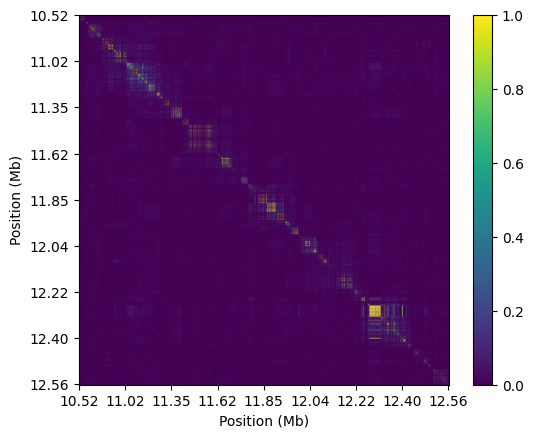

In [82]:
sub_LD_local[np.isnan(sub_LD_local)] = 0

data = sub_LD_local
region_idx = np.arange(data.shape[1])      # 例：全部列
kb_pos = positions[region_idx] / 1e6      # 转成 kb

fig, ax = plt.subplots()
im = ax.imshow(data)

# 1. 把刻度位置设成 0,1,2...（即列号）
ax.set_xticks(np.arange(0, len(region_idx), max(1, len(region_idx)//8)))
# 2. 把刻度标签换成对应的 kb 值，保留两位小数
ax.set_xticklabels([f"{kb:.2f}" for kb in kb_pos[::max(1, len(region_idx)//8)]])
ax.set_xlabel("Position (Mb)")

# y 轴同理，如果 y 方向也是 bp 坐标，照抄即可：
ax.set_yticks(np.arange(0, len(region_idx), max(1, len(region_idx)//8)))
# 2. 把刻度标签换成对应的 kb 值，保留两位小数
ax.set_yticklabels([f"{kb:.2f}" for kb in kb_pos[::max(1, len(region_idx)//8)]])
ax.set_ylabel("Position (Mb)")

plt.colorbar(im)
plt.show()

In [1]:
import allel
from scipy.spatial.distance import squareform
callset = allel.read_vcf("/mnt/qmtang/EvoFill_data/20251225_chr22_IGL/data/major_pops_train.vcf.gz")
g = allel.GenotypeArray(callset['calldata/GT'][callset['variants/CHROM'] == 'chr22'])
gn = g.to_n_alt(fill=-1)
r = allel.rogers_huff_r(gn)
major_LD = squareform(r ** 2)

callset = allel.read_vcf("/mnt/qmtang/EvoFill_data/20251225_chr22_IGL/data/minor_pops_all.vcf.gz")
g = allel.GenotypeArray(callset['calldata/GT'][callset['variants/CHROM'] == 'chr22'])
gn = g.to_n_alt(fill=-1)
r = allel.rogers_huff_r(gn)
minor_LD = squareform(r ** 2)

/home/qmtang/miniconda3/envs/mamba/lib/python3.10/site-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: '##INFO=<ID=END2,Type=Integer,Number=1,Description="Position of breakpoint on CHR2">\n'
  warnings.warn('invalid INFO header: %r' % header)


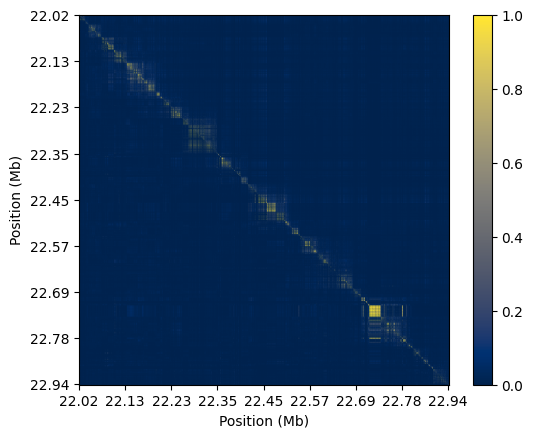

In [11]:
major_LD = np.nan_to_num(major_LD, nan=0.0)
minor_LD = np.nan_to_num(minor_LD, nan=0.0)

# 2. 拼出完整矩阵：上三角用 major，下三角用 minor
#    对角线两边都算也行，这里把对角线留给 major_LD，可自己改
n = major_LD.shape[0]
combined = np.triu(major_LD, k=0) + np.tril(minor_LD, k=-1)

kb_pos = positions[region_idx] / 1e6      # 转成 kb

fig, ax = plt.subplots()
im = ax.imshow(combined,cmap='cividis')

# 1. 把刻度位置设成 0,1,2...（即列号）
ax.set_xticks(np.arange(0, len(region_idx), max(1, len(region_idx)//8)))
# 2. 把刻度标签换成对应的 kb 值，保留两位小数
ax.set_xticklabels([f"{kb:.2f}" for kb in kb_pos[::max(1, len(region_idx)//8)]])
ax.set_xlabel("Position (Mb)")

# y 轴同理，如果 y 方向也是 bp 坐标，照抄即可：
ax.set_yticks(np.arange(0, len(region_idx), max(1, len(region_idx)//8)))
# 2. 把刻度标签换成对应的 kb 值，保留两位小数
ax.set_yticklabels([f"{kb:.2f}" for kb in kb_pos[::max(1, len(region_idx)//8)]])
ax.set_ylabel("Position (Mb)")

plt.colorbar(im)
plt.show()

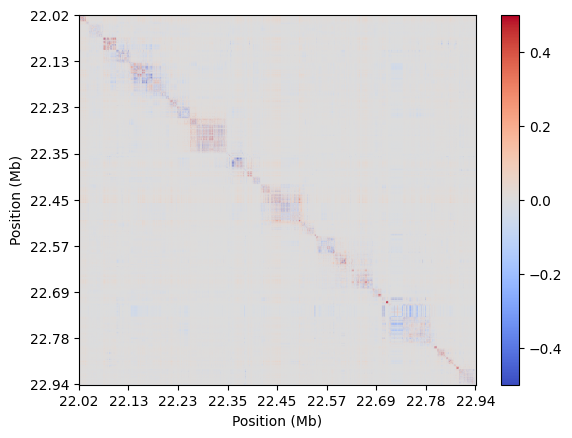

In [15]:
# 2. 计算差值矩阵
delta = major_LD - minor_LD

fig, ax = plt.subplots()
im = ax.imshow(delta,cmap='coolwarm', vmin=-0.5, vmax=0.5, aspect='auto')

# 1. 把刻度位置设成 0,1,2...（即列号）
ax.set_xticks(np.arange(0, len(region_idx), max(1, len(region_idx)//8)))
# 2. 把刻度标签换成对应的 kb 值，保留两位小数
ax.set_xticklabels([f"{kb:.2f}" for kb in kb_pos[::max(1, len(region_idx)//8)]])
ax.set_xlabel("Position (Mb)")

# y 轴同理，如果 y 方向也是 bp 坐标，照抄即可：
ax.set_yticks(np.arange(0, len(region_idx), max(1, len(region_idx)//8)))
# 2. 把刻度标签换成对应的 kb 值，保留两位小数
ax.set_yticklabels([f"{kb:.2f}" for kb in kb_pos[::max(1, len(region_idx)//8)]])
ax.set_ylabel("Position (Mb)")

plt.colorbar(im)
plt.show()